In [31]:
from matplotlib import pyplot as plt
import numpy as np
from eeg_v2 import EEG
from utils import chunks, baseline_calc, butter_bandpass_filter
import random
from mne.preprocessing import ICA

In [9]:
# Reading raw data
path_edf="./edf/1578_alice/edf/A0001578.edf"
path_stage="./edf/1578_alice/csv/STAGE.csv"

eeg = EEG(path_edf=path_edf, path_stage=path_stage)

In [111]:
# Params
_window = 15
_fs = 500

In [35]:
# Preprocessing function
def f(eeg):
    
    # Getting randome chunk of data from raw signal
    _chunk = random.choice(list(chunks(random.choice(eeg.tasks), _window)))
    _min, _max = np.min(_chunk), np.max(_chunk)

    
    # Preprocessing
    # Getting sample data
    sample_raw = eeg.raw.copy().crop(_min, _max, include_tmax=False)
    eog_channels = eeg.eog_channels.copy().crop(_min, _max, include_tmax=False)

    # Apply baseline correction
    sample_raw_baseline = sample_raw.copy()
    sample_raw_baseline.apply_function(baseline_calc)
    # eog_channels.apply_function(baseline_calc)

    # Apply bandpass filter
    sample_raw_bandpass = sample_raw_baseline.copy()
    sample_raw_bandpass.apply_function(butter_bandpass_filter)
    
    # Applying ICA
    sample_raw_train = sample_raw_bandpass.copy()
    sample_raw_corrected = sample_raw_bandpass.copy()

    # Train
    ica = ICA(method="extended-infomax", random_state=1)
    ica.fit(sample_raw_corrected)
    
    return _min, _max, sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_corrected, ica

In [40]:
_min, _max, sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_corrected, ica = f(eeg)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 10
Computing Extended Infomax ICA
Fitting ICA took 2.8s.


In [135]:
plt.rcParams["figure.figsize"] = (10, 7)
def d(sig, _fs, title, _is_ica=False):
    
    #Number of channels/components 
    if _is_ica:
        _sig = sig.get_sources(inst=sample_raw_train).get_data()
        ch_names = sig.get_sources(inst=sample_raw_train).ch_names
    else:
        _sig = sig.get_data()
        ch_names = sig.ch_names
        
    n, l = _sig.shape
    
    fig, axes = plt.subplots(n, 1)
    
    for i in range(n):    
        ax = axes[i]
        
        ax.plot(np.linspace(0, l/_fs, l),              # Time axis
                 _sig[i,:],                            # Signal
                 linewidth = .5,
                 color = 'black')
        
        ax.set_title(ch_names[i], loc='left')
        ax.axis('off')
    fig.suptitle(title, fontsize=20)
    return fig
    

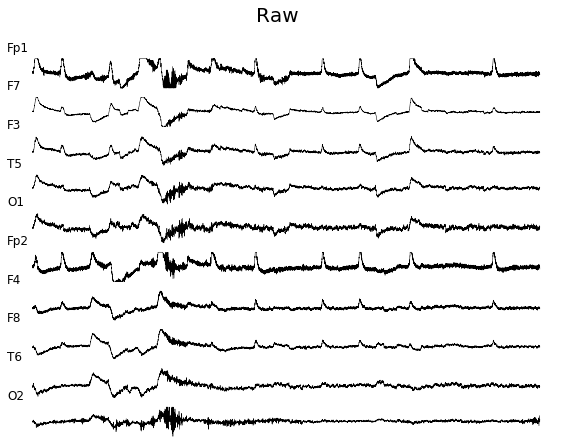

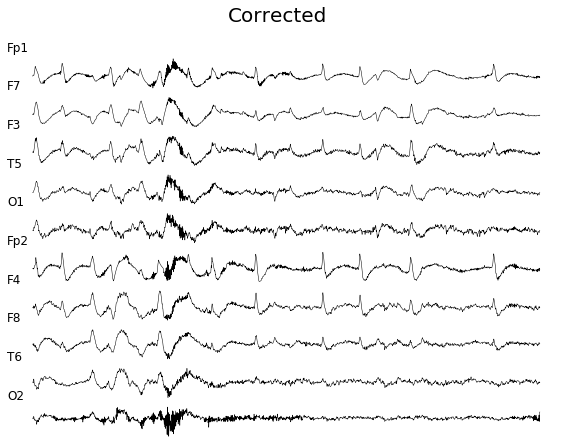

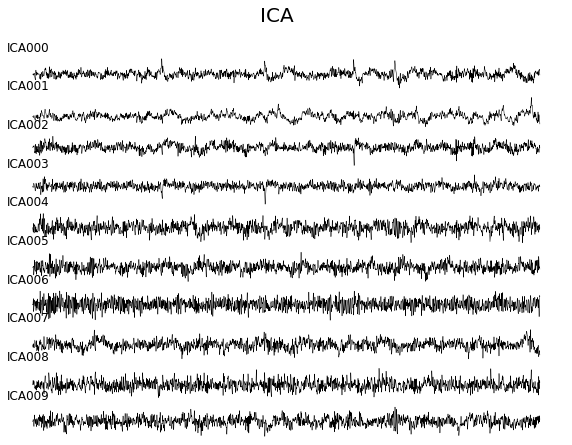

<Figure size 720x504 with 0 Axes>

In [135]:
d(sample_raw, 500, "Raw")
d(sample_raw_corrected, 500, "Corrected")
d(ica, 500, "ICA", _is_ica=True)
plt.show()

In [ ]:
def draw_figure():
    """
    ---
    Return:
    - Plot of ICs
    - Raw signal plot
    - Reconstructed signal plot
    """